# Abstract and Introduction

As media becomes the main source of important news, the authenticity of those news becomes one of the most important things. The ultimate goal of the Fake News Challenge is meant to identify fake news through computers automatically. In order to achieve this ultimate goal, people need to approach the ideal results step by step. At the first step of this challenge, people need to teach computers to classify whether a headline and the associated body text are related or not. The baseline method provided by the organizers of this challenge is a gradient boosting classifier associated with 10-fold cross-validation. In this project, we propose a deep learning model using the idea Siamese model to check whether a headline and a body text are related. We first extract features from headlines and body texts using one-dimensional CNN respectively. And then we implement an MLP classifier to decide the relationship between a headline and the associated body text. The relationship between a headline and a body text contains agree, disagree, discuss, or unrelated. 

In [ ]:
from dataset import *

In [ ]:
dataset = DataSet()

Reading dataset
Total stances: 49972
Total bodies: 1683


In [ ]:
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/zerono614/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/zerono614/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Baseline

Running baseline method. The train datast is first divided into train dataset and validation dataset. 

And the train dataset is separated into 10 folds to do `cross validation`. Then the baseline method uses a `gradient boosting classifier` to classify the relationship between headlines and body texts.

In [ ]:
!python3 fnc_kfold.py > output/baseline_output.txt

### Read the baseline_output.txt and output the results

Read the `baseline_output.txt` and output the results on `dev set` and on `test set`.

In [ ]:
import os
ref_t = []
with open(os.path.join('output','baseline_output.txt')) as r:
    # In the file, the lines from line 226 is the results
    # Before line 226 is the results on 10 folds
    for line in (r.readlines() [226:]): 
            print(line, end ='') 

Scores on the dev set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    115    |     8     |    557    |    82     |
-------------------------------------------------------------
| disagree  |    16     |     3     |    128    |    15     |
-------------------------------------------------------------
|  discuss  |    60     |     3     |   1530    |    207    |
-------------------------------------------------------------
| unrelated |     5     |     1     |    96     |   6796    |
-------------------------------------------------------------
Score: 3540.0 out of 4448.5	(79.57738563560751%)


Scores on the test set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    167    |    11     

# Deep learning

We apply a neural network model named `Siamese Neural Network` to the `Fake News Stance Detection`. 

The neural network contains two parts. 

`1. One-dimensional CNN model`

We use one dimensional CNN model to extract two 768-dimension feature from sentence embeddings of headlines and body texts respectively. 

`2. MLP Classifier`

We use a 1536-dimension vector, which is concatenated from two 768-dimension vectors from CNNs as the input of this MLP and output a 4-dimension vector which indicates the 4 categories of the relationship between headlines and body texts, including `Agree`, `Disagree`, `Discuss` and `Unrelated`.

### Import necessary libraries

This part import necessary libraries and download `nltk` data.

In [153]:
# https://github.com/FakeNewsChallenge/fnc-1-baseline
from fnc_kfold import *
from feature_engineering import *
from tqdm import tqdm
import nltk
import torch
import torch.nn as nn
import random

In [154]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Create dataset

This part separate the training data into train set and validation set. The percentage is 0.8. 

In [155]:
# Use helper functions to separate the train dataset into train set and validation set
dataset = DataSet()
folds,hold_out = kfold_split(dataset,n_folds=1)
train_stances, validation_stances = get_stances_for_folds(dataset,folds,hold_out)

Reading dataset
Total stances: 49972
Total bodies: 1683


In [156]:
# Get headlines in train set and validation set
train_headlines = []
validation_headlines = []

for stance in train_stances[0]:
  train_headlines.append(stance['Headline'])

for stance in validation_stances:
  validation_headlines.append(stance['Headline'])

In [157]:
# Get all body texts
bodies = []

for _, body in tqdm(dataset.articles.items()):
  bodies.append(body)


100%|██████████| 1683/1683 [00:00<00:00, 1390116.90it/s]


## Create sentence embeddings

This part use a pre-trained network named `InferSent` to obtain the `sentence embeddings`. `InferSent` is a sentence embeddings method that provides semantic representations for English sentences. `InferSent` uses word-embeddings from `fastText` to generate 4096-dimensional sentence embeddings for sentences with variable lengths.

In [6]:
# Download fastText word embeddings
!mkdir fastText
!wget -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip -d fastText/

Archive:  crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [7]:
# Download pre-trained InferSent model
!mkdir encoder
!wget -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [160]:
# https://github.com/facebookresearch/InferSent
# Load the pre-trained model 
from models import InferSent
model_version = 2
MODEL_PATH = "infersent2.pkl"
W2V_PATH = 'fastText/crawl-300d-2M.vec'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
use_cuda = True
infersent = infersent.cuda() if use_cuda else infersent
infersent.set_w2v_path(W2V_PATH)

In [ ]:
# Make directory for sentence embeddings
!mkdir embeddings

In [161]:
# Encode headlines in train set to sentence embeddings
infersent.build_vocab(train_headlines, tokenize=True)
train_headlines_embeddings = infersent.encode(train_headlines, bsize=128, tokenize=True)
np.save("embeddings/train_headlines.npy", train_headlines_embeddings)

Found 4691(/4930) words with w2v vectors
Vocab size : 4691


In [162]:
# Encode headlines in validation set to sentence embeddings
infersent.build_vocab(validation_headlines, tokenize=True)
validation_headlines_embeddings = infersent.encode(validation_headlines, bsize=128, tokenize=True)
np.save("embeddings/validation_headlines.npy", validation_headlines_embeddings)

Found 4577(/4806) words with w2v vectors
Vocab size : 4577


In [163]:
# Encode body texts to sentence embeddings
infersent.build_vocab(bodies, tokenize=True)
bodies_embeddings = infersent.encode(bodies, bsize=16, tokenize=True)
np.save("embeddings/bodies.npy", bodies_embeddings)

Found 28141(/31492) words with w2v vectors
Vocab size : 28141


## Copy the obtained embeddings to Google drive for later use

In [164]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
!cp "embeddings/train_headlines.npy" "/content/drive/My Drive/embeddings"
!cp "embeddings/validation_headlines.npy" "/content/drive/My Drive/embeddings"
!cp "embeddings/bodies.npy" "/content/drive/My Drive/embeddings"

## Read pre-obtained embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [145]:
!mkdir embeddings
!cp "/content/drive/My Drive/embeddings/train_headlines.npy" "embeddings/train_headlines.npy"
!cp "/content/drive/My Drive/embeddings/validation_headlines.npy" "embeddings/validation_headlines.npy" 
!cp "/content/drive/My Drive/embeddings/bodies.npy" "embeddings/bodies.npy" 

mkdir: cannot create directory ‘embeddings’: File exists


In [166]:
# Load sentence embeddings for headlines in train set and validation set and body texts
train_headlines_embeddings = np.load("embeddings/train_headlines.npy")
validation_headlines_embeddings = np.load("embeddings/validation_headlines.npy")
bodies_embeddings = np.load("embeddings/bodies.npy" )

## Create data loader

This part create data loader for the training process.

In [167]:
# Load sentence embeddings for body texts into a dictionary
# {key = Body ID, value = sentence embeddings}
bodies_embeddings_dict = {}
ind = 0
for i, body in dataset.articles.items():
  bodies_embeddings_dict[i] = bodies_embeddings[ind]
  ind += 1 

In [168]:
# Make headline-body pairs
def make_pairs(headlines_embs, bodies_embs_dict, stances):
    pairs, labels = [], []
    for i, stance in enumerate(stances):
        headline = torch.cuda.FloatTensor(headlines_embs[i])
        body = torch.cuda.FloatTensor(bodies_embs_dict[stance['Body ID']])
        pairs.append(torch.cat([headline, body]).view(1, 8192))  
        labels.append(LABELS.index(stance['Stance']))
    return torch.cat(pairs), torch.cuda.LongTensor(labels)

In [169]:
batch = 128
pairs_train, labels_train = make_pairs(train_headlines_embeddings, bodies_embeddings_dict, train_stances[0])
train = torch.utils.data.dataset.TensorDataset(pairs_train, labels_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)

pairs_valid, labels_valid = make_pairs(validation_headlines_embeddings, bodies_embeddings_dict, validation_stances)
valid = torch.utils.data.dataset.TensorDataset(pairs_valid, labels_valid)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch, shuffle=True)

## Build CNN model and Classifier model for this task

In [170]:
class FakeNewsCNN(nn.Module):
    ''' FakeNews CNN model '''

    def __init__(self, dropout=0.2):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels = 4096, out_channels = 2048, kernel_size = 1)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(in_channels = 2048, out_channels = 2048, kernel_size = 1)
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv1d(in_channels = 2048, out_channels = 1024, kernel_size = 1)
        self.conv4 = nn.Conv1d(in_channels = 1024, out_channels = 1024, kernel_size = 1)
        self.dropout3 = nn.Dropout(dropout)
        self.conv5 = nn.Conv1d(in_channels = 1024, out_channels = 1024, kernel_size = 1)
        self.conv6 = nn.Conv1d(in_channels = 1024, out_channels = 768, kernel_size = 1)

        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(2048)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.batchnorm4 = nn.BatchNorm1d(1024)
        self.batchnorm5 = nn.BatchNorm1d(1024)

    def forward(self, x):

        x = self.dropout1(self.relu(self.batchnorm1(self.conv1(x))))
        x = self.dropout2(self.relu(self.batchnorm2(self.conv2(x))))
        x = self.relu(self.batchnorm3(self.conv3(x)))         
        x = self.dropout3(self.relu(self.batchnorm4(self.conv4(x))))
        x = self.relu(self.batchnorm5(self.conv5(x)))
        x = self.conv6(x)
        
        return x

In [171]:
class FakeNewsClassifier(nn.Module):
    ''' FakeNews classifier model '''

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1536, 1024) 
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, 256) 
        self.linear3 = nn.Linear(256, 4) 
        self.softmax = nn.Softmax()
        

    def forward(self, x):

        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

### Build models

In [184]:
fakeCNN = FakeNewsCNN().type(torch.cuda.FloatTensor)
fakeClassifier = FakeNewsClassifier().type(torch.cuda.FloatTensor)

## Train

In [185]:
import torch.optim as optim
from torch.autograd import Variable
FloatTensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor

In [186]:
params = [x for x in fakeCNN.parameters()] + [x for x in fakeClassifier.parameters()]
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=params, lr=0.00001, betas=(0.1, 0.001), eps=1e-08,) # 210
# optimizer = torch.optim.Adam(params=params, lr=0.000005, betas=(0.1, 0.001), eps=1e-08,) # 500
# optimizer = torch.optim.Adam(params=params, lr=0.000005, eps=1e-08,) # this one
optimizer = torch.optim.Adam(params=params, lr=0.00002, eps=1e-08,) # this one
# optimizer = torch.optim.Adam(params=params, lr=0.00001) 
# optimizer = torch.optim.SGD(params=params, lr=0.0001, momentum=0.9)

In [187]:
# Record to be plotted
plot_training_loss = []
plot_validation_loss = []
plot_training_score = []
plot_validation_score = []

### Training process

In [ ]:
epochs = 1600
num = int(len(labels_train)/batch) + 1
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_preds = []
    train_actuals = []
    for i, (pairs, labels) in tqdm(enumerate(train_loader), position=0, leave=True):
        fakeCNN.train()
        fakeClassifier.train()

        if len(labels) < batch:
          n_train = len(labels)
        else:
          n_train = batch

        headlines, bodies = pairs.view(n_train, -1).split(4096, dim=1)
        headlines = Variable(headlines.type(FloatTensor)).view(n_train, 4096, 1)
        bodies = Variable(bodies.type(FloatTensor)).view(n_train, 4096, 1)
        labels = Variable(labels).type(LongTensor)
        # zero the parameter gradients
        # optimizer.zero_grad()
        fakeCNN.zero_grad()
        fakeClassifier.zero_grad()
        
        # forward + backward + optimize
        headline_feats = fakeCNN(headlines)
        body_feats = fakeCNN(bodies)
        headline_body = torch.cat((headline_feats, body_feats), 1).view(n_train, -1)
        pred = fakeClassifier(headline_body)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        _, pred_l = torch.max(pred, 1)
        train_pred = [LABELS[int(a)] for a in pred_l.cpu().tolist()]
        train_actual = [LABELS[int(a)] for a in labels.cpu().tolist()]

        train_preds = train_preds + train_pred
        train_actuals = train_actuals + train_actual

        # print statistics
        running_loss += loss.item()
        if (i + 1) % num == 0:
        # if (epoch + 1) % 25 == 0:
          fakeCNN.eval()
          fakeClassifier.eval()
          actual_labels = []
          predicted_labels = []
          valid_running_loss = []
          for k, (p, l) in enumerate(valid_loader):
              if len(l) < batch:
                n = len(l)
              else:
                n = batch
              h, b = p.view(n, -1).split(4096, dim=1)
              h = Variable(h.type(FloatTensor)).view(n, 4096, 1)
              b = Variable(b.type(FloatTensor)).view(n, 4096, 1)
              l = Variable(l).type(LongTensor)
              h_f = fakeCNN(h).view(n, 768)
              b_f = fakeCNN(b).view(n, 768)
              h_b = torch.cat((h_f, b_f), 1)
              out = fakeClassifier(h_b)
              valid_loss = criterion(out, l)
              valid_running_loss.append(valid_loss.item())
              _, predicted = torch.max(out, 1)

              predicted = [LABELS[int(a)] for a in predicted.cpu().tolist()]
              actual = [LABELS[int(a)] for a in l.cpu().tolist()]

              predicted_labels = predicted_labels + predicted
              actual_labels = actual_labels + actual

          score,_ = score_submission(actual_labels,predicted_labels)
          best_score, _ = score_submission(actual_labels,actual_labels)
          final_score = score*100/best_score
          plot_validation_score.append(final_score)
          print('[TEST] Epoch %i/%i [step %i/%i] score: %.3f' % (epoch + 1, epochs, i + 1, int(labels_train.size()[0]) / batch, final_score))
          print("Training running loss: ", running_loss/num)
          print("Valid running loss: ", sum(valid_running_loss)/len(valid_running_loss))
          plot_training_loss.append(running_loss/num)
          plot_validation_loss.append(sum(valid_running_loss)/len(valid_running_loss))
          running_loss = 0.0
    score,_ = score_submission(train_actuals,train_preds)
    best_score, _ = score_submission(train_actuals,train_actuals)
    final_score = score*100/best_score
    plot_training_score.append(final_score)
    print("Training score: ", final_score)
    if (epoch + 1) % 100 == 0:
      torch.save(fakeCNN, "models/fakeCNN" + str(epoch) + ".pt")
      torch.save(fakeClassifier, "models/fakeClassifier" + str(epoch) + ".pt")
print('Finished Training')

### Save models to Google Drive

In [132]:
# torch.save(fakeCNN, "fakeCNN_new1.pt")
# torch.save(fakeClassifier, "fakeClassifier_new1.pt")

In [194]:
!cp -r "/content/models" "/content/drive/My Drive/FakeNewsModels/" 
# !cp "fakeClassifier_new1.pt" "/content/drive/My Drive/FakeNewsModels"

### Load model Google Drive


In [134]:
!cp "/content/drive/My Drive/FakeNewsModels/fakeCNN_new1.pt" "fakeCNN.pt"
!cp "/content/drive/My Drive/FakeNewsModels/fakeClassifier_new1.pt" "fakeClassifier.pt" 

In [242]:
fakeCNN = torch.load("models/fakeCNN1599.pt")
fakeClassifier = torch.load("models/fakeClassifier1599.pt")

## Plot results

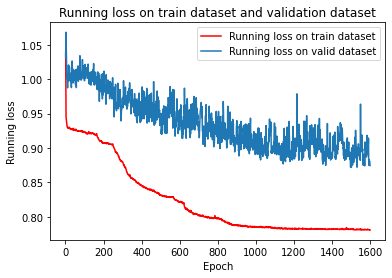

In [195]:
import matplotlib.pyplot as plt
plot_epochs = np.arange(1, 1600+1)
plt.plot(plot_epochs, plot_training_loss, 'r-', plot_epochs, plot_validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Running loss")
plt.title("Running loss on train dataset and validation dataset")
plt.legend(['Running loss on train dataset', 'Running loss on valid dataset'])
plt.show()

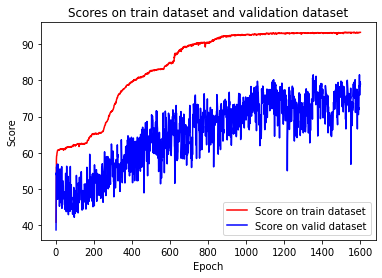

In [196]:
plt.plot(plot_epochs, plot_training_score, 'r-', plot_epochs, plot_validation_score, 'b-')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Scores on train dataset and validation dataset")
plt.legend(['Score on train dataset', 'Score on valid dataset'])
plt.show()

## Calculate score on test dataset

In [197]:
test_dataset = DataSet("competition_test")
test_headlines = []

for stance in test_dataset.stances:
  test_headlines.append(stance['Headline'])

Reading dataset
Total stances: 25413
Total bodies: 904


In [198]:
test_bodies = []

for _, body in tqdm(test_dataset.articles.items()):
  test_bodies.append(body)


100%|██████████| 904/904 [00:00<00:00, 849193.91it/s]


In [199]:
from models import InferSent
model_version = 2
MODEL_PATH = "infersent2.pkl"
W2V_PATH = 'fastText/crawl-300d-2M.vec'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
use_cuda = True
infersent = infersent.cuda() if use_cuda else infersent
infersent.set_w2v_path(W2V_PATH)

In [200]:
infersent.build_vocab(test_headlines, tokenize=True)
test_headlines_embeddings = infersent.encode(test_headlines, bsize=128, tokenize=True)
np.save("embeddings/test_headlines.npy", test_headlines_embeddings)

Found 3147(/3293) words with w2v vectors
Vocab size : 3147


In [201]:
infersent.build_vocab(test_bodies, tokenize=True)
test_bodies_embeddings = infersent.encode(test_bodies, bsize=16, tokenize=True)
np.save("embeddings/test_bodies.npy", test_bodies_embeddings)

Found 20887(/22611) words with w2v vectors
Vocab size : 20887


In [202]:
!cp "embeddings/test_headlines.npy" "/content/drive/My Drive/embeddings"
!cp "embeddings/test_bodies.npy" "/content/drive/My Drive/embeddings"

### Load test embeddings

In [105]:
!mkdir embeddings
!cp "/content/drive/My Drive/embeddings/test_headlines.npy" "embeddings/"
!cp "/content/drive/My Drive/embeddings/test_bodies.npy" "embeddings/" 

In [106]:
test_headlines_embeddings = np.load("embeddings/test_headlines.npy")
test_bodies_embeddings = np.load("embeddings/test_bodies.npy" )

### Calculate score

In [203]:
test_bodies_embeddings_dict = {}
ind = 0
for i, body in test_dataset.articles.items():
  test_bodies_embeddings_dict[i] = test_bodies_embeddings[ind]
  ind += 1 

In [204]:
pairs_test, labels_test = make_pairs(test_headlines_embeddings, test_bodies_embeddings_dict, test_dataset.stances)
test = torch.utils.data.dataset.TensorDataset(pairs_test, labels_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch, shuffle=True)

In [205]:

len(labels_test)

25413

In [243]:
test_preds = []
test_actuals = []
for i, (pairs, labels) in tqdm(enumerate(test_loader), position=0, leave=True):
    fakeCNN.eval()
    fakeClassifier.eval()

    if len(labels) < batch:
      n_test = len(labels)
    else:
      n_test = batch

    headlines, bodies = pairs.view(n_test, -1).split(4096, dim=1)
    headlines = Variable(headlines.type(FloatTensor)).view(n_test, 4096, 1)
    bodies = Variable(bodies.type(FloatTensor)).view(n_test, 4096, 1)
    labels = Variable(labels).type(LongTensor)
    
    # forward + backward + optimize
    headline_feats = fakeCNN(headlines)
    body_feats = fakeCNN(bodies)
    headline_body = torch.cat((headline_feats, body_feats), 1).view(n_test, -1)
    pred = fakeClassifier(headline_body)
    _, pred_l = torch.max(pred, 1)
    test_pred = [LABELS[int(a)] for a in pred_l.cpu().tolist()]
    test_actual = [LABELS[int(a)] for a in labels.cpu().tolist()]

    test_preds = test_preds + test_pred
    test_actuals = test_actuals + test_actual

score = report_score(test_actuals, test_preds)
print("Testing score: ", score)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
199it [00:02, 67.57it/s]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    286    |    65     |    275    |   1277    |
-------------------------------------------------------------
| disagree  |    94     |    14     |    110    |    479    |
-------------------------------------------------------------
|  discuss  |    303    |    38     |   1670    |   2453    |
-------------------------------------------------------------
| unrelated |    451    |    128    |   1087    |   16683   |
-------------------------------------------------------------
Score: 6362.0 out of 11651.25	(54.60358330651218%)
Testing score:  54.60358330651218


# Generate output files

In [ ]:
import os

In [244]:
def generate_files(torch_loader):
  preds = []
  actuals = []
  for i, (pairs, labels) in tqdm(enumerate(torch_loader), position=0, leave=True):
      fakeCNN.eval()
      fakeClassifier.eval()

      if len(labels) < batch:
        n = len(labels)
      else:
        n = batch

      headlines, bodies = pairs.view(n, -1).split(4096, dim=1)
      headlines = Variable(headlines.type(FloatTensor)).view(n, 4096, 1)
      bodies = Variable(bodies.type(FloatTensor)).view(n, 4096, 1)
      labels = Variable(labels).type(LongTensor)
      
      # forward + backward + optimize
      headline_feats = fakeCNN(headlines)
      body_feats = fakeCNN(bodies)
      headline_body = torch.cat((headline_feats, body_feats), 1).view(n, -1)
      pred = fakeClassifier(headline_body)
      _, pred_l = torch.max(pred, 1)
      pred = [LABELS[int(a)] for a in pred_l.cpu().tolist()]
      actual = [LABELS[int(a)] for a in labels.cpu().tolist()]

      preds = preds + pred
      actuals = actuals + actual
  return preds, actuals
  

In [245]:
def output(set_name, preds, actuals):
  pred_file = set_name + "_preds.txt"
  actual_file = set_name + "_actuals.txt"
  with open(pred_file, "w") as w:
    for p in preds:
      w.write(p + '\n')
  with open(actual_file, "w") as w:
    for a in actuals:
      w.write(a + '\n') 

In [246]:
train_preds, train_actuals = generate_files(train_loader)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
316it [00:04, 67.48it/s]


In [225]:
output("train", train_preds, train_actuals)

In [247]:
report_score(train_actuals, train_preds)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |   1770    |    99     |    736    |    311    |
-------------------------------------------------------------
| disagree  |    125    |    380    |    104    |    69     |
-------------------------------------------------------------
|  discuss  |    19     |     0     |   6708    |    382    |
-------------------------------------------------------------
| unrelated |     6     |     0     |    36     |   29605   |
-------------------------------------------------------------
Score: 16530.0 out of 18114.75	(91.2516043555666%)


91.2516043555666

In [248]:
validation_preds, validation_actuals = generate_files(valid_loader)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
76it [00:01, 68.86it/s]


In [226]:
output("validation", validation_preds, validation_actuals)

In [249]:
report_score(validation_actuals, validation_preds)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    325    |    20     |    261    |    156    |
-------------------------------------------------------------
| disagree  |    33     |    55     |    44     |    30     |
-------------------------------------------------------------
|  discuss  |    116    |    12     |   1356    |    316    |
-------------------------------------------------------------
| unrelated |    60     |    16     |    203    |   6619    |
-------------------------------------------------------------
Score: 3512.25 out of 4448.5	(78.95357985837923%)


78.95357985837923

In [250]:
test_preds, test_actuals = generate_files(test_loader)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
199it [00:02, 66.78it/s]


In [227]:
output("test", test_preds, test_actuals)

In [251]:
report_score(test_actuals, test_preds)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    286    |    65     |    275    |   1277    |
-------------------------------------------------------------
| disagree  |    94     |    14     |    110    |    479    |
-------------------------------------------------------------
|  discuss  |    303    |    38     |   1670    |   2453    |
-------------------------------------------------------------
| unrelated |    451    |    128    |   1087    |   16683   |
-------------------------------------------------------------
Score: 6362.0 out of 11651.25	(54.60358330651218%)


54.60358330651218